In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Question 1

In [23]:
default = pd.read_csv("/Users/brandonk87/Downloads/MSC 641/Stacking/Default-1.csv")
dummies_sex = pd.get_dummies(default['SEX'], prefix='Sex')
dummies_edu = pd.get_dummies(default['EDUCATION'], prefix='Education')
dummies_mar = pd.get_dummies(default['MARRIAGE'], prefix='Marriage')
default = pd.concat([default, dummies_sex, dummies_edu, dummies_mar], axis=1)
default = default.drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
default_col = default.pop('default payment next month')
default = pd.concat([default, default_col], axis=1)
default.head()

LIMIT_BAL  AGE  PAY_0  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  \
0      20000   24      2      2     -1     -1     -2     -2       3913   
1     120000   26     -1      2      0      0      0      2       2682   
2      90000   34      0      0      0      0      0      0      29239   
3      50000   37      0      0      0      0      0      0      46990   
4      50000   57     -1      0     -1      0      0      0       8617   

   BILL_AMT2  ...  Sex_1  Sex_2  Education_1  Education_2  Education_3  \
0       3102  ...      0      1            0            1            0   
1       1725  ...      0      1            0            1            0   
2      14027  ...      0      1            0            1            0   
3      48233  ...      0      1            0            1            0   
4       5670  ...      1      0            0            1            0   

   Education_4  Marriage_1  Marriage_2  Marriage_3  default payment next month  
0            0           1           0           0                           1  
1            0           0           1           0                           1  
2            0           0           1           0                           0  
3            0           1           0           0                           0  
4            0           1           0           0                           0  

[5 rows x 30 columns]

In [24]:
from sklearn.model_selection import train_test_split
x = default.iloc[:,:-1]
y = default.iloc[:,-1:]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=13)

# Question 2

In [25]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
x_train.iloc[:,:20] = sc.fit_transform(x_train.iloc[:,:20])
x_test.iloc[:,:20] = sc.transform(x_test.iloc[:,:20])

# Question 3

In [26]:
import math
p = round(math.sqrt(x_train.shape[1]))
p

5

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score

baselearner = list()
    # Empty list where you are going to put the base learners in
baselearner.append(('lr', LogisticRegression()))
baselearner.append(('knn', KNeighborsClassifier(n_neighbors=5)))
baselearner.append(('tree', DecisionTreeClassifier(random_state=13)))
baselearner.append(('rf', RandomForestClassifier(n_estimators = 100, random_state = 13, max_features = p)))
    # How you build and each base learner

metalearner = LogisticRegression()
    # Defining the meta model

stack = StackingClassifier(estimators=baselearner, final_estimator=metalearner, cv=5)
    # use stack_methods to do predicted labels (default) or predicted probability
stack.fit(x_train, y_train)
pred_stack = stack.predict(x_test)
print("Test accuracy for stacking ensemble:",accuracy_score(pred_stack,y_test))
accuracy = accuracy_score(pred_stack,y_test)

/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

Test accuracy for stacking ensemble: 0.82


In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred_stack)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("Classification accuracy is", accuracy)
print("The MR is:",(FP + FN)/len(y_test))

[[4462  212]
 [ 868  458]]
The FNR is: 0.3164179104477612
The FPR is: 0.1628517823639775
Classification accuracy is 0.82
The MR is: 0.18


AUC: 0.7749424627492286


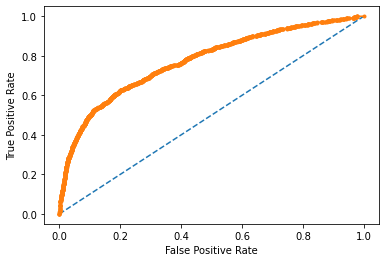

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
pred_test_prob = stack.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))

# Question 4

In [30]:
baselearner = list()
baselearner.append(('tree5', DecisionTreeClassifier(random_state=13, max_depth = 5)))
baselearner.append(('tree10', DecisionTreeClassifier(random_state=13, max_depth = 10)))
baselearner.append(('tree20', DecisionTreeClassifier(random_state=13, max_depth = 20)))
baselearner.append(('tree_none', DecisionTreeClassifier(random_state=13, max_depth = None)))

metalearner = LogisticRegression()

stack2 = StackingClassifier(estimators=baselearner, final_estimator=metalearner, cv=5)
stack2.fit(x_train, y_train)
pred_stack2 = stack2.predict(x_test)
accuracy2 = accuracy_score(pred_stack2,y_test)

/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[4498  176]
 [ 892  434]]
The FNR is: 0.28852459016393445
The FPR is: 0.16549165120593692
Classification accuracy is 0.822
The MR is: 0.178
AUC: 0.7587344160533771


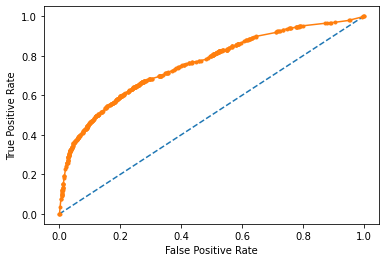

In [31]:
cm = confusion_matrix(y_test, pred_stack2)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("Classification accuracy is", accuracy2)
print("The MR is:",(FP + FN)/len(y_test))
pred_test_prob = stack2.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))

# Question 5

In [32]:
from sklearn.ensemble import GradientBoostingClassifier
baselearner = list()
baselearner.append(('lr', LogisticRegression()))
baselearner.append(('lr_lasso', LogisticRegression(penalty = 'l1', solver = 'liblinear')))
baselearner.append(('lr_ridge', LogisticRegression(penalty = 'l2')))
baselearner.append(('knn', KNeighborsClassifier(n_neighbors = 5)))
baselearner.append(('tree', DecisionTreeClassifier(random_state = 13)))
baselearner.append(('tree1', DecisionTreeClassifier(random_state = 13, max_depth = 1)))
baselearner.append(('rf', RandomForestClassifier(n_estimators = 100, random_state = 13, max_features = p)))
baselearner.append(('gradient', GradientBoostingClassifier(max_depth = 3)))

metalearner = LogisticRegression()

stack3 = StackingClassifier(estimators=baselearner, final_estimator=metalearner, cv=5)
stack3.fit(x_train, y_train)
pred_stack3 = stack3.predict(x_test)
accuracy3 = accuracy_score(pred_stack3,y_test)

/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/brandonk87/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[[4450  224]
 [ 834  492]]
The FNR is: 0.3128491620111732
The FPR is: 0.1578349735049205
Classification accuracy is 0.8236666666666667
The MR is: 0.17633333333333334
AUC: 0.7863998945419318


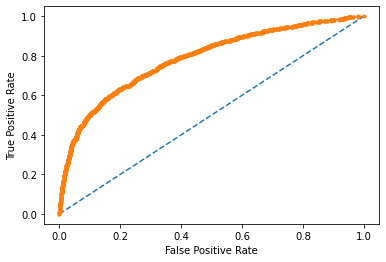

In [33]:
cm = confusion_matrix(y_test, pred_stack3)
TN = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TP = cm[1,1]
print(cm)
print("The FNR is:", FN/(TP+FN))
print("The FPR is:",FP/(FP+TN))
print("Classification accuracy is", accuracy3)
print("The MR is:",(FP + FN)/len(y_test))
pred_test_prob = stack3.predict_proba(x_test)
mr_probs = [0 for _ in range(len(y_test))]
mr_fpr, mr_tpr, _ = roc_curve(y_test, mr_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, pred_test_prob[:,1])
plt.plot(mr_fpr, mr_tpr, linestyle='--')
plt.plot(lr_fpr, lr_tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print("AUC:",metrics.auc(lr_fpr, lr_tpr))